In [ ]:
import cv2
import numpy as np

# Read image
img = cv2.imread("/Users/liujiaen/Documents/Text_Recognition/final_project/testimage/IMG_3490.jpg")

# Convert to grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# rgb_planes = cv2.split(img)

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imwrite('shadows_out.png', result)
cv2.imwrite('shadows_out_norm.png', result_norm)


In [ ]:
# result,type(result)

In [33]:
import pandas as pd
import numpy as np

# read data

df = pd.read_csv("/Users/liujiaen/Documents/Text_Recognition/final_project/saved.csv")

df.head()

,id,correct,date,naive_date_confidence,total,naive_total_confidence,text
0,4,True,2017-02-27 12:29:14,0.687667,6.74,0.667967,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
1,5,True,2017-02-26 11:10:32,0.689433,11.16,0.667933,city\nCRF-CITY LA ROCHELLE\n33 RUE DE LA SCIER...
2,6,True,2017-02-25 11:05:35,0.704167,6.99,0.668133,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
3,9,True,2016-05-23 12:29:03,0.697633,5.04,0.668100,CRF-CITY LA ROCHELLE\n33 RUE DE LA SCIERIE\n17...
4,10,True,2016-04-22 20:25:13,0.685633,14.46,0.667833,Carrefour\ncity\nCRF-CITY LA ROCHELLE\n33 RUE ...


In [ ]:
true_df = df[df['correct'] == True]
true_df.head()

In [34]:
false_df = df[df['correct'] == False]
false_df.head()

,id,correct,date,naive_date_confidence,total,naive_total_confidence,text
32,73,False,2016-01-20 19:11:51,0.693567,0.10,0.334600,Carrefour city\nCRF-CITY LA ROCHELLE\n33 RUE D...
56,146,False,2016-11-17 13:12:23,0.685333,3.11,0.668300,Carrefour\ncity\nCRF-CITY LA ROCHELLE\n33 RUE ...
66,168,False,2017-01-13 13:48:44,0.693800,12.41,0.334933,﻿city\nCRF-CITY LA ROCHELLE\n33 RUE DE LA SCIE...
97,248,False,2016-12-18 12:17:39,0.685467,27.49,0.667567,Carrefour\nmarket\nCarrefour market AYTRE\nTel...
99,257,False,2016-06-11 13:54:04,0.675800,156.00,0.667633,﻿Carrefour\nmarke t\nCarrefour market AYTRE\nT...


In [36]:
false_df.to_csv("/Users/liujiaen/Documents/Text_Recognition/final_project/false.csv", index=False)

In [ ]:
true_df.drop(['correct','naive_date_confidence','naive_total_confidence','text'], axis=1, inplace=True)
true_df.head()

In [ ]:
true_df.shape

## Now let us use layoutLMv2 to extract date and amount from the invoice

In [1]:
import os
import cv2
import uuid
from PIL import Image, ImageDraw, ImageFont
import numpy as np

import torch
import torchvision.transforms as torchvision_T
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_mobilenet_v3_large
from transformers import LayoutLMv2ForTokenClassification, LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast
from datasets import load_dataset
# from torchvision.datasets.utils import download_file_from_google_drive

In [4]:
dataset = load_dataset("darentang/sroie", split="test")
    # define id2label, label2color
labels = dataset.features['ner_tags'].feature.names
print(labels)

Found cached dataset sroie (/Users/liujiaen/.cache/huggingface/datasets/darentang___sroie/sroie/1.0.0/26ed9374c9a15a1d2f44fd8886f679076e1a1fd7da2d53726d6e58a99436c506)


['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']


In [5]:
labels[1:-1]

['B-COMPANY',
 'I-COMPANY',
 'B-DATE',
 'I-DATE',
 'B-ADDRESS',
 'I-ADDRESS',
 'B-TOTAL']

In [2]:
def get_layoutlmv2(ocr_lang = "fra"):
    feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang=ocr_lang,tesseract_config="--psm 12 --oem 2")
    tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased")
    # processor = LayoutLMv2Processor(feature_extractor, tokenizer)
    model = LayoutLMv2ForTokenClassification.from_pretrained("Theivaprakasham/layoutlmv2-finetuned-sroie")
    return tokenizer, feature_extractor, model

def get_labels():
    # dataset = load_dataset("darentang/sroie", split="test")
    # define id2label, label2color
    labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']
    id2label = {v: k for v, k in enumerate(labels)}
    label2color = {'B-ADDRESS': 'blue',
    'B-COMPANY': 'green',
    'B-DATE': 'red',
    'B-TOTAL': 'red',
    'I-ADDRESS': "blue",
    'I-COMPANY': 'green',
    'I-DATE': 'red',
    'I-TOTAL': 'red',
    'O': 'green'}

    label2color = dict((k.lower(), v.lower()) for k,v in label2color.items())
    return id2label, label2color

# Unnormalize the bounding box coordinates.
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

# iob to label
def iob_to_label(label):
    return label



In [7]:
def process_image(image, feature_extractor, tokenizer, model, id2label, label2color):
    """
    Process the image and return predictions.

    Args:
        image (PIL.Image): Image to be processed.
        # processor (LayoutLMv2Processor): LayoutLMv2 processor.
        feature_extractor (LayoutLMv2FeatureExtractor): LayoutLMv2 feature extractor.
        tokenizer (LayoutLMv2TokenizerFast): LayoutLMv2 tokenizer.
        model (LayoutLMv2ForTokenClassification): LayoutLMv2 model.
        id2label (dict): Dictionary mapping label id to label name.
        label2color (dict): Dictionary mapping label name to color.
    Returns:
        PIL.Image: Image with predictions drawn on it.
    """
    if not os.path.exists("error_images"):
        os.mkdir("error_images")
    width, height = image.size

    # encode the image, get the bounding boxes and the words
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    # print(encoding_feature_extractor.keys())
    # print(encoding_feature_extractor.words)
    # TODO: apply the regex to the words
    words, boxes = encoding_feature_extractor.words[0], encoding_feature_extractor.boxes[0]
    # print(words)
    text = " ".join(words)
    encoding = tokenizer(words, boxes=boxes, return_offsets_mapping=True, return_tensors="pt", truncation=True)
    # encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    encoding["image"] = encoding_feature_extractor.pixel_values

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for k, v in encoding.items():
        encoding[k] = v.to(device)

    model.to(device)

    # forward pass
    outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    # TODO:Read the paper and understand the offset_mapping
    # Keep length of words, predictions and boxes equal

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    # print(is_subword)
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

    true_predictions = true_predictions[1:-1]
    true_boxes = true_boxes[1:-1]

    

    print(len(words),len(true_predictions),len(true_boxes))
    # if length of words, predictions and boxes are not equal, then save the image
    if len(words) != len(true_predictions) or len(words) != len(true_boxes):
        image.save("error_images/" +str(uuid.uuid4()) + ".jpg")
        print("There is an error when processing the image. Please check the error_images folder.")
    print(words)
    print(true_predictions)


    json_df = []

    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    # print(zip(true_predictions, true_boxes))
    for ix, (prediction, box) in enumerate(zip(true_predictions, true_boxes)):
        predicted_label = iob_to_label(prediction).lower()
        if prediction != 'O' and prediction != 'o':
            json_dict = {}

            json_dict["TEXT"] =  words[ix]
            json_dict["LABEL"] = predicted_label
            
            json_df.append(json_dict)
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

    # get the text from the labeled box 
    # print(text)
    return image, text, json_df,true_predictions

image = Image.open("/Users/liujiaen/Documents/Text_Recognition/final_project/testimage/4.jpg")

# resize the image
image = image.resize((600, 1200))

tokenizer, feature_extractor, layoutLMv2 = get_layoutlmv2()
id2label, label2color = get_labels()

image, text, json_df, true_prediction = process_image(image, feature_extractor, tokenizer, layoutLMv2, id2label, label2color)
print(json_df)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
90 90 90
['<41', 'c1ty', 'CRF—CITY', 'LA', 'ROCHELLE', '33', 'RUE', 'DE', 'LA', 'SCIERIE', '17000', 'LÀ', 'ROCHELLE', 'Tel', '05.', '46', '.27', '0212', 'DESCRIPTION', 'Ore', 'NONTANT', '+85G', 'VERRINE', 'TIRAKI', '2.01€', '*PARNENTIER', 'CANARD', '4.73€', 'posmesees', 'voe', '*', 'Rgn0ttoraetitens', 'dosse', 'posste', 'ts', '2', 'ARTICLE', '(b)', 'a', 'casoteuscere', 'TOTAL', 'A', 'PAVER', '6.74€', 'Etouatestposotokonr', 'ester', 'CB', 'EMV', 'SAN', 'ONTAGT', 'EUR', '6.74€', 'Si', 'vous', 'aviez', 'la', 'carte', 'fidélité', 'vous', 'auriez', 'cumulé', '0.30€', 'sur', 'votre', 'compte', 'fidélité', 'Carrefour', 'one', 'Détails:', 'vome', 'à—', 'sebecoWgeé', 'lblite',

In [43]:
text

'PRIMEURS 17 06 63 28 50 44 Balance : 3 Client : 31 Date 10/06/2017 11 : 45 VYendeur : 4 DELPHINE Rayon 1 » Num Ticket 197 Kg € ”/ K9 abricot 1, 045 3, 90 4, 08 avocat l 2n ATt 7 1 50 3, 00 TOTAL: à ,08 Dont TVA 5,50 %: 0: 31 € Potal ” TVA 0,97 Total HT 6 ,. 71 2 transaction(s) 3 Article(+) Ë.-un.Auusnuunn.nﬂih-.—u;—..….- À à à à à'

In [40]:
json_df

[{'TEXT': '10/06/2017', 'LABEL': 'b-date'}]

In [12]:
import re

In [28]:
date = []
total = ""
for i in range(len(json_df)):
    if "date" in json_df[i]["LABEL"] :
        # date = json_df[i]["TEXT"]
        date.append(json_df[i]["TEXT"])
        print(json_df[i]["TEXT"])
    elif "total" in json_df[i]["LABEL"]:
        total = re.sub(r'[^\d.]', '', json_df[i]["TEXT"])
        print(float(total))

5.04
23/05/2016


In [ ]:
# resive the image

import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("/Users/liujiaen/Documents/Text_Recognition/final_project/test_scripts/985.jpg")

# resize the image
img = cv2.resize(img, 600, )

In [26]:
" ".join(date)

'23/05/2016'

In [41]:
from dateutil.parser import parse
test = parse(" ".join(date), fuzzy=True)

In [42]:
test.date()

datetime.date(2016, 5, 23)

In [32]:
import datetime

test.date() == datetime.datetime.strptime(" ".join(date), '%d/%m/%Y').date()

True

In [ ]:
IMG_PATH = "/Users/liujiaen/Documents/Text_Recognition/dataset/findit/FindIt-Dataset-Train/T1-train/img"



In [ ]:
true_prediction

In [45]:
text

'PRIMEURS 17 06 63 28 50 44 Balance : 3 Client : 31 Date 10/06/2017 11 : 45 VYendeur : 4 DELPHINE Rayon 1 » Num Ticket 197 Kg € ”/ K9 abricot 1, 045 3, 90 4, 08 avocat l 2n ATt 7 1 50 3, 00 TOTAL: à ,08 Dont TVA 5,50 %: 0: 31 € Potal ” TVA 0,97 Total HT 6 ,. 71 2 transaction(s) 3 Article(+) Ë.-un.Auusnuunn.nﬂih-.—u;—..….- À à à à à'

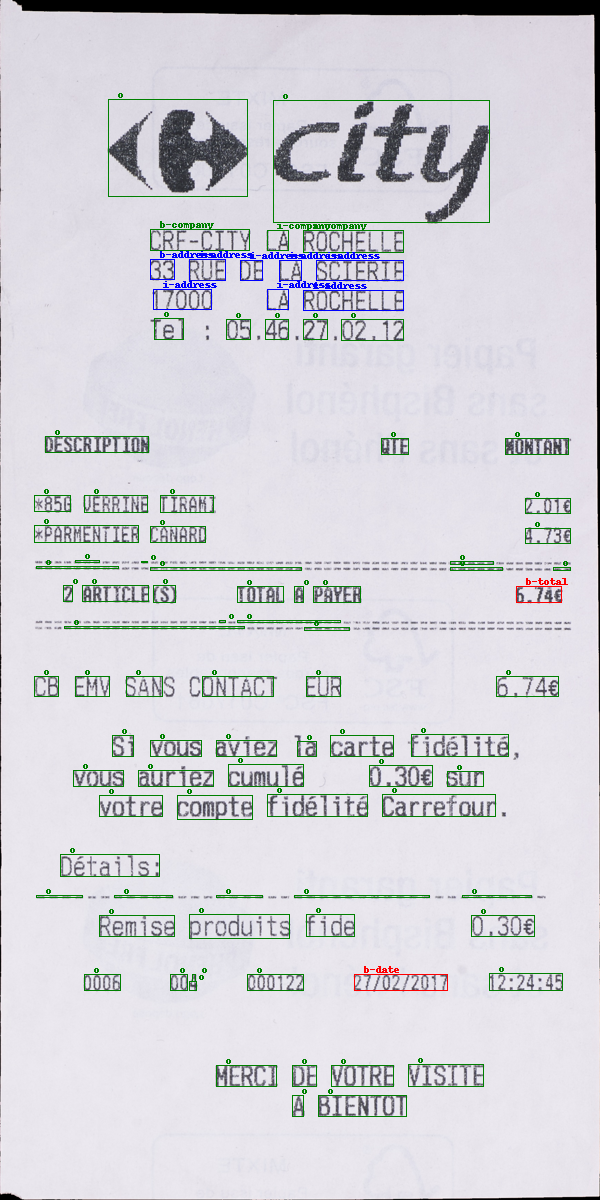

In [8]:
image